In [1]:
#https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                        parse_dates=["Date"],
                        index_col=["Date"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


Text(0.5, 1.0, 'Price of bitcoin')

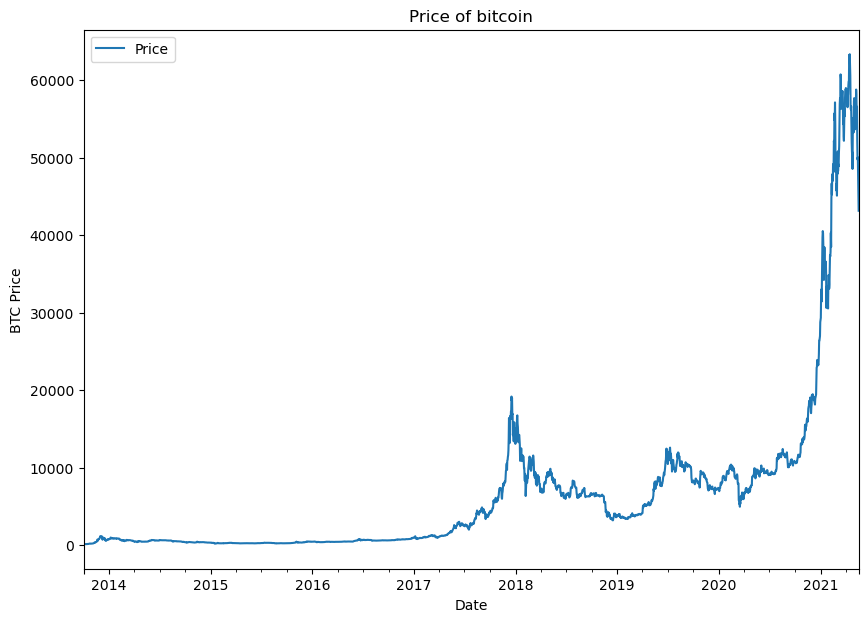

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of bitcoin")

In [6]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [7]:
#011 Reading in our Bitcoin data with Python's CSV module
#012 Creating train and test splits for time series (the wrong way)
#013 Creating train and test splits for time series (the right way)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bitcoin_prices.index.to_numpy(), bitcoin_prices['Price'].to_numpy(), test_size=0.2,shuffle=False, random_state=42)

In [8]:
# #The other way
# timesteps = bitcoin_prices.index.to_numpy()
# prices = bitcoin_prices["Price"].to_numpy()
# split_size = int(0.8 * len(prices)) # 80% train, 20% test
# X_train, y_train = timesteps[:split_size], prices[:split_size]
# X_test, y_test = timesteps[split_size:], prices[split_size:]
#
# len(X_train), len(X_test), len(y_train), len(y_test)

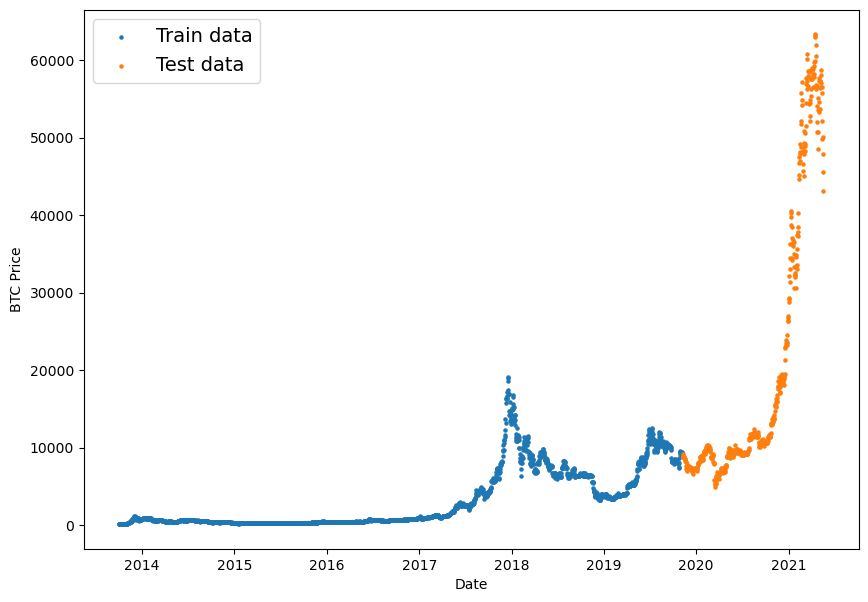

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [10]:
#014 Creating a plotting function to visualize our time series data
def plot_time_series(timesteps,values,format=".",start=0,end = None,label=None):
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)


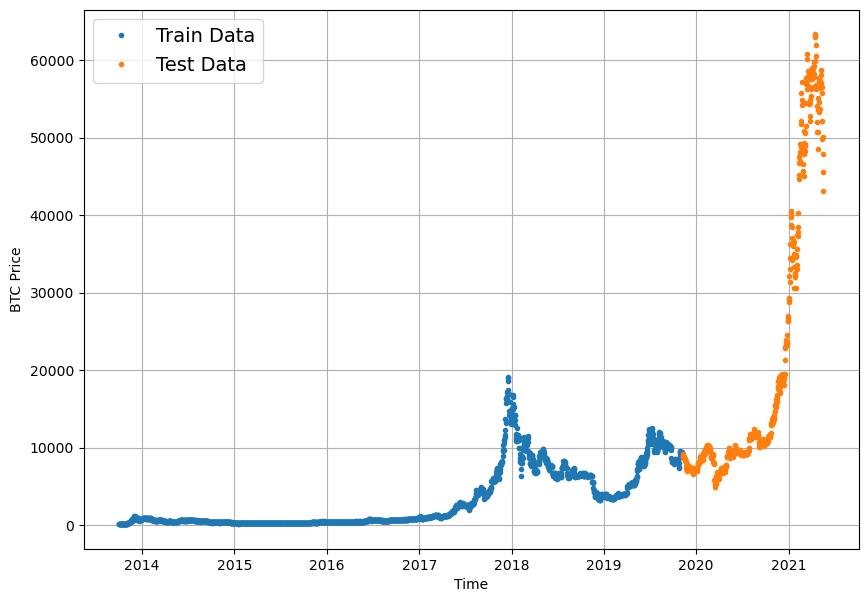

In [11]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,label="Test Data")

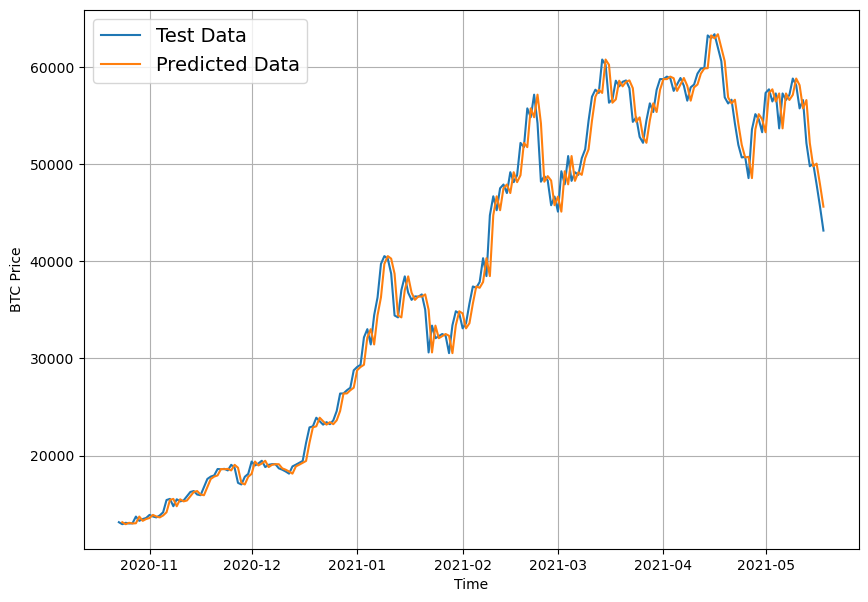

In [12]:
#015 Discussing the various modelling experiments were going to be running
#016 Model 0 Making and visualizing a naive forecast model
# naive forecast at time t is the value at (t-1)
naive_forecast = y_test[:-1]
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,start=350,format="-",label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,start=350,format="-",label="Predicted Data")


In [13]:
#017 Discussing some of the most common time series evaluation metrics
#018 Implementing MASE with TensorFlow
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):

    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae / mae_naive_no_season

In [14]:
mean_absolute_scaled_error(y_true=y_test[1:],y_pred=naive_forecast).numpy()

0.9995699939182624

In [15]:
#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [16]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [17]:
#020 Discussing other non-TensorFlow kinds of time series forecasting models
#021 Formatting data Part 2 Creating a function to label our windowed time series
bitcoin_prices['Price'].to_numpy()[:7]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [18]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_window(x,horizon=HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [19]:
#022 Discussing the use of windows and horizons in time series data
#023 Writing a preprocessing function to turn time series data into windows & labels
import numpy as np
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes = window_step +np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    windowed_array = x[window_indexes]
    windows,labels = get_labelled_window(windowed_array,horizon=horizon)
    return windows,labels

In [20]:
full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)

In [21]:
full_windows

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          121.33866   ,   120.65533   ,   121.795     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          121.795     ,   123.033     ,   124.049     ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        52147.82118698, 49764.1320816 , 50032.69313676],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361]])

In [22]:
#Insted of above , the below can also be used
# data = [x for x in range(21)]
# input_data = data[:-3]
# targets = data[3:]
# dataset = tf.keras.utils.timeseries_dataset_from_array(
#     input_data, targets, sequence_length=3)
#
# for batch in dataset:
#   inputs, targets = batch
#   print(inputs,targets)

In [23]:
#024 Turning our windowed time series data into training and test sets
def make_train_test_splits(windows,labels,test_split=0.2):
    split_size = int(len(windows)*(1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows,test_windows,train_labels,test_labels

In [24]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [25]:
#025 Creating a modelling checkpoint callback to save our best performing model
import os

def create_model_checkpoint(model_name,save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True,monitor='val_loss',)

In [26]:
#026 Model 1 Building, compiling and fitting a deep learning model on Bitcoin data
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON,activation = 'linear')
],name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mse'])

model_1.fit(x = train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,

            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 [==============================] - 3s 43ms/step - loss: 1939.5863 - mae: 1939.5863 - mse: 11395057.0000 - val_loss: 1046.2582 - val_mae: 1046.2582 - val_mse: 3355244.2500
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 364.9219 - mae: 364.9219 - mse: 505415.8750 - val_loss: 1678.8262 - val_mae: 1678.8262 - val_mse: 6653237.5000
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 219.4219 - mae: 219.4219 - mse: 220421.7188 - val_loss: 934.2008 - val_mae: 934.2008 - val_mse: 2748263.2500
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 164.8061 - mae: 164.8061 - mse: 141680.6562 - val_loss: 872.6711 - val_mae: 872.6711 - val_mse: 2569916.2500
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 159.7376 - mae: 159.7376 - mse: 137022.9844 - val_loss: 879.5466 - val_mae: 879.5466 - val_mse: 2459597.2500
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 150.4

In [27]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 624.4889 - mae: 624.4889 - mse: 1284613.2500


[624.4888916015625, 624.4888916015625, 1284613.25]

In [28]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.7103 - mae: 568.7103 - mse: 1177579.8750


[568.7102661132812, 568.7102661132812, 1177579.875]

In [29]:
#027 Creating a function to make predictions with our trained models
def make_preds(model,input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [30]:
model_1_preds = make_preds(model_1,test_windows)

18/18 [==============================] - 0s 2ms/step


In [31]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 568.71027,
 'mse': 1177579.9,
 'rmse': 1085.1636,
 'mape': 2.5525587,
 'mase': 0.9990664}

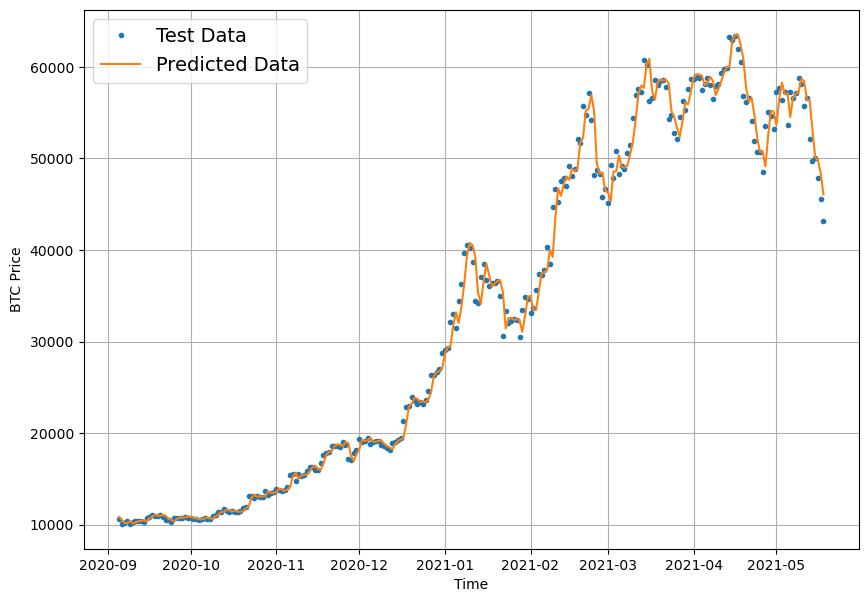

In [32]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds,start=offset,format="-",label="Predicted Data")

In [33]:
#028 Model 2 Building, fitting and evaluating a deep model with a larger window size
HORIZON = 1
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [34]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [35]:
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 636.9738 - mae: 636.9738


[636.9737548828125, 636.9737548828125]

In [36]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 633.8625 - mae: 633.8625


[633.8624877929688, 633.8624877929688]

In [37]:
model_2_preds = make_preds(model_2,input_data=test_windows,)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

18/18 [==============================] - 0s 1ms/step


{'mae': 633.8624,
 'mse': 1395150.1,
 'rmse': 1181.1647,
 'mape': 2.8030505,
 'mase': 1.1079978}

In [38]:
model_1_results

{'mae': 568.71027,
 'mse': 1177579.9,
 'rmse': 1085.1636,
 'mape': 2.5525587,
 'mase': 0.9990664}

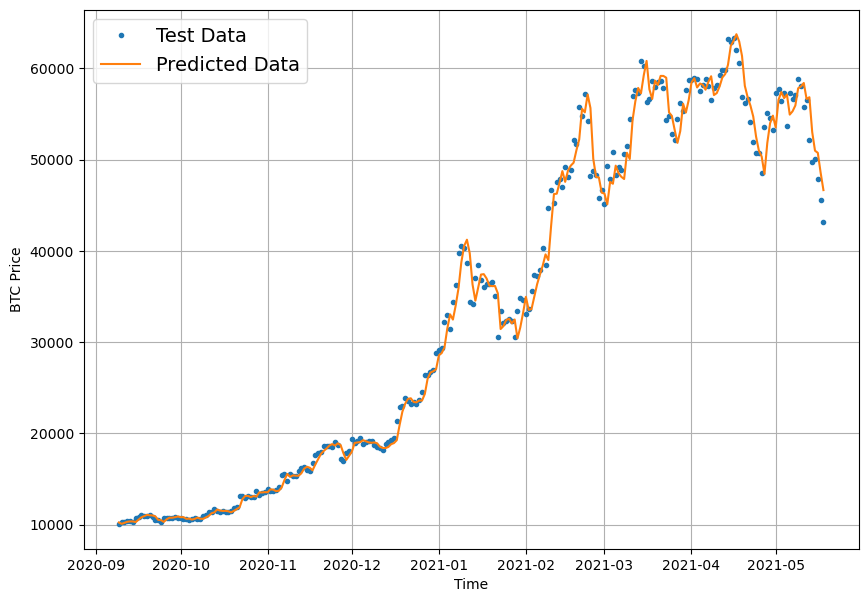

In [39]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format="-",label="Predicted Data")

In [40]:
#029 Model 3 Building, fitting and evaluating a model with a larger horizon size
HORIZON = 7
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [41]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name= 'model_3_dense')

model_3.compile(loss='MAE',
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [42]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1413.7593


1413.75927734375

In [43]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 1s 9ms/step - loss: 1231.6782


1231.67822265625

In [44]:
model_3_preds = make_preds(model_3,input_data=test_windows)

18/18 [==============================] - 0s 5ms/step


In [45]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  718.01575 ,   310.7747  ,   322.0823  ,   442.387   ,
          445.05707 ,   509.01373 ,   549.2822  ,   644.295   ,
          473.62674 ,   486.90707 ,   737.5516  ,   872.328   ,
          892.96    ,   888.86523 ,   673.77783 ,   293.93597 ,
          253.22322 ,   273.94315 ,   166.13051 ,   307.40332 ,
          162.75858 ,   196.2869  ,   457.0233  ,   380.22098 ,
          225.5032  ,   100.28202 ,   122.74714 ,    91.27246 ,
          149.83078 ,   180.71658 ,   384.83713 ,   412.8127  ,
          367.1563  ,   440.556   ,   314.22614 ,   311.49847 ,
          353.64865 ,   289.23334 ,   228.30344 ,   204.35477 ,
          389.42026 ,    69.509415,    53.398506,    98.35087 ,
           82.92745 ,   151.8012  ,   138.48465 ,   134.43283 ,
           90.922714,   124.743515,    93.33614 ,   165.7491  ,
          224.14182 ,   208.65681 ,   251.07652 ,   370.9986  ,
          504.8674  ,   473.8476  ,   468.9802  ,   478.50272 ,
          330.0604  ,   191.86893

In [46]:
#030 Adjusting the evaluation function to work for predictions with larger horizons

#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    #Account for diff size metrics for longer horizon

    if mae.ndim>0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [47]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1231.6781,
 'mse': 5362330.5,
 'rmse': 1417.3463,
 'mape': 5.572655,
 'mase': 2.1917024}

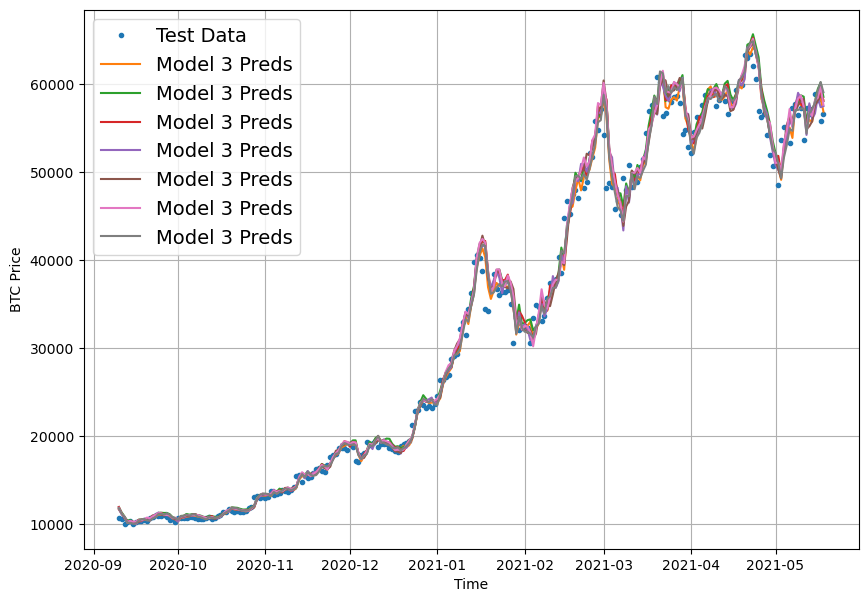

In [48]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_3_preds,start=offset,format='-',label="Model 3 Preds")

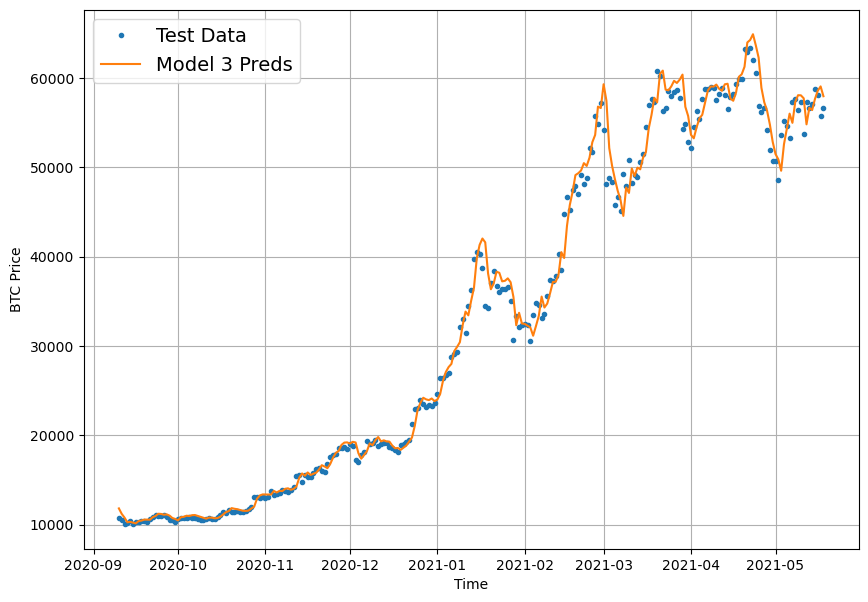

In [49]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format='-',label="Model 3 Preds")

<Axes: >

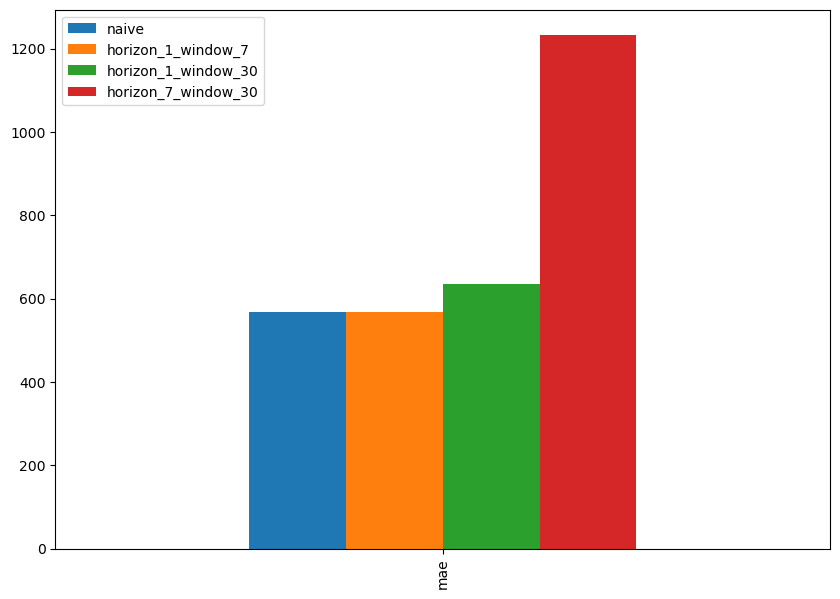

In [50]:
#032 Comparing our modelling experiments so far and discussing autocorrelation

pd.DataFrame({"naive":naive_results["mae"],
             "horizon_1_window_7":model_1_results["mae"],
             "horizon_1_window_30":model_2_results["mae"],
             "horizon_7_window_30":model_3_results["mae"],},index=['mae']).plot(figsize=(10,7),kind = "bar")


In [51]:
#033 Preparing data for building a Conv1D model
HORIZON = 1
WINDOW_SIZE = 7

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [52]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [53]:
#input shape : (batch_size,timesteps,input_dim)
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))

In [54]:
#034 Model 4 Building, fitting and evaluating a Conv1D model on our Bitcoin data
tf.random.set_seed(42)
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128,kernel_size=5 , strides = 1,padding = 'causal',activation = 'relu' ),
    layers.Dense(HORIZON)
],name = "model_4_conv1D")

model_4.compile(loss="mae",optimizer=tf.keras.optimizers.Adam())
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


In [55]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 601.7449


601.7449340820312

In [57]:
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 572.4139


572.4139404296875

In [58]:
model_4_preds = make_preds(model_4,test_windows)
model_4_preds

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8865.503 ,  8766.124 ,  9009.764 ,  8789.333 ,  8703.278 ,
        8737.887 ,  8671.449 ,  8527.339 ,  8444.244 ,  8515.935 ,
        8264.326 ,  8102.061 ,  8061.4253,  7709.9556,  7330.357 ,
        7272.497 ,  7108.5005,  7157.0703,  7136.215 ,  7421.4917,
        7449.3364,  7654.6523,  7630.6025,  7411.787 ,  7353.7915,
        7309.6973,  7233.248 ,  7336.594 ,  7494.0317,  7536.784 ,
        7558.014 ,  7384.6006,  7255.7607,  7202.2485,  7180.241 ,
        7217.7583,  7103.895 ,  7089.348 ,  6925.6143,  6631.7495,
        7230.876 ,  7249.5127,  7120.0703,  7266.3374,  7266.4287,
        7216.371 ,  7208.0664,  7225.366 ,  7193.2305,  7215.1562,
        7298.577 ,  7381.962 ,  7286.545 ,  7189.389 ,  7177.1797,
        6997.868 ,  7205.199 ,  7341.997 ,  7346.254 ,  7653.126 ,
        8016.5894,  8125.1226,  7890.3193,  8045.7646,  8135.9824,
        8151.3135,  8132.7437,  8616.832 ,  8894.733 ,  8765.807 ,
        8911.7

In [59]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_4_preds)
model_4_results

{'mae': 572.4139,
 'mse': 1189196.2,
 'rmse': 1090.5027,
 'mape': 2.5811472,
 'mase': 1.0055727}

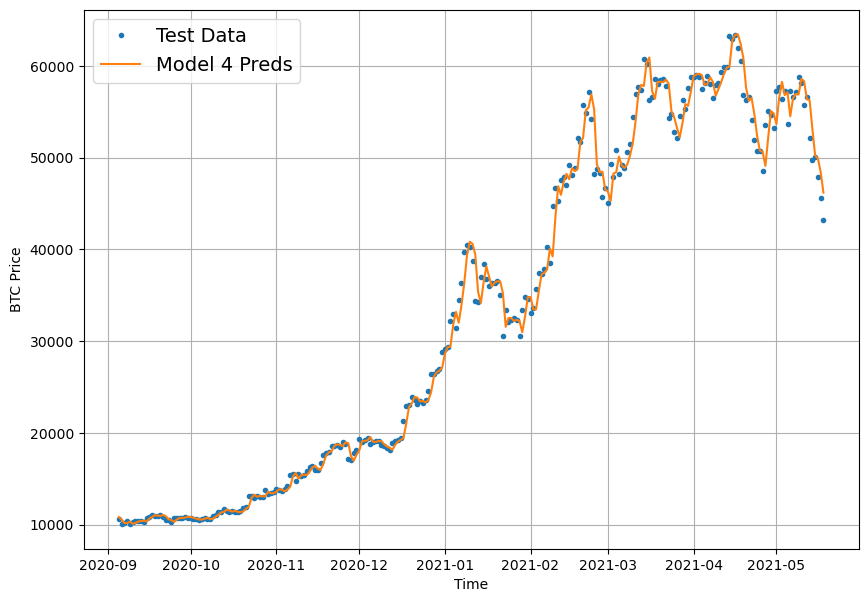

In [60]:
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_4_preds,start=offset,format='-',label="Model 4 Preds")

In [61]:
#035 Model 5 Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data
tf.random.set_seed(42)
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
#x = layers.LSTM(128,return_sequences = True)(x)
x = layers.LSTM(128,activation='relu')(x)
#x = layers.Dense(32,activation = 'relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs,outputs = output,name='model_5_LSTM')

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 2484.2742INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 210ms/step - loss: 2455.8735 - val_loss: 11023.9102
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1054.2872INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 178ms/step - loss: 1054.2872 - val_loss: 2010.6862
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 277.7207INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 205ms/step - loss: 275.3516 - val_loss: 1110.4337
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 210.0253INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 221ms/step - loss: 206.9944 - val_loss: 1052.1448
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 191.4189 - val_loss: 1110.9031
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 181.5157INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 256ms/step - loss: 183.9874 - val_loss: 1000.0460
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 176.7712 - val_loss: 1040.1731
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 182.3036 - val_loss: 1038.3203
Epoch 9/100
18/18 [==============================] - 0s 13ms/step - loss: 182.7820 - val_loss: 1037.0177
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 182.5722 - val_loss: 1043.7664
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 182.0246 - val_loss: 1026.3458
Epoch 12/100
18/18 [==============================] - 0s 11ms/step - loss: 178.7637 - val_loss: 1010.6061
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 173.6831INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 225ms/step - loss: 176.3692 - val_loss: 998.7714
Epoch 14/100
18/18 [==============================] - 0s 11ms/step - loss: 174.9518 - val_loss: 1029.1470
Epoch 15/100
18/18 [==============================] - 0s 11ms/step - loss: 174.4981 - val_loss: 1005.6930
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 173.5645INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 285ms/step - loss: 171.9124 - val_loss: 959.9573
Epoch 17/100
18/18 [==============================] - 0s 14ms/step - loss: 170.4949 - val_loss: 1021.2079
Epoch 18/100
18/18 [==============================] - 0s 15ms/step - loss: 169.8245 - val_loss: 999.2496
Epoch 19/100
18/18 [==============================] - 0s 13ms/step - loss: 167.3554 - val_loss: 987.9927
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 165.3251INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 240ms/step - loss: 166.4101 - val_loss: 930.9667
Epoch 21/100
18/18 [==============================] - 0s 17ms/step - loss: 164.0433 - val_loss: 937.0400
Epoch 22/100
18/18 [==============================] - 0s 12ms/step - loss: 162.4563 - val_loss: 931.5361
Epoch 23/100
18/18 [==============================] - 0s 14ms/step - loss: 162.6792 - val_loss: 952.0927
Epoch 24/100
14/18 [======================>.......] - ETA: 0s - loss: 158.2515INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 147ms/step - loss: 159.3201 - val_loss: 898.9897
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 161.7823INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 169ms/step - loss: 156.9011 - val_loss: 889.1307
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 156.9183INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 285ms/step - loss: 155.8192 - val_loss: 887.1467
Epoch 27/100
16/18 [=========================>....] - ETA: 0s - loss: 154.2041INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 242ms/step - loss: 154.1515 - val_loss: 875.9921
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 149.9013INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 187ms/step - loss: 152.3467 - val_loss: 857.7452
Epoch 29/100
14/18 [======================>.......] - ETA: 0s - loss: 151.0980INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 128ms/step - loss: 150.3679 - val_loss: 848.9802
Epoch 30/100
18/18 [==============================] - 0s 12ms/step - loss: 150.1154 - val_loss: 866.1240
Epoch 31/100
13/18 [====================>.........] - ETA: 0s - loss: 149.7564INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 143ms/step - loss: 148.0454 - val_loss: 818.2740
Epoch 32/100
18/18 [==============================] - 0s 11ms/step - loss: 147.1926 - val_loss: 826.7880
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 145.2939 - val_loss: 863.0383
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 145.2929INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 96ms/step - loss: 145.2929 - val_loss: 793.1064
Epoch 35/100
18/18 [==============================] - 0s 11ms/step - loss: 141.6107 - val_loss: 808.6472
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 142.1988INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 102ms/step - loss: 142.9954 - val_loss: 781.5221
Epoch 37/100
18/18 [==============================] - 0s 9ms/step - loss: 139.4580 - val_loss: 800.0631
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 138.3186INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 101ms/step - loss: 138.2625 - val_loss: 762.2309
Epoch 39/100
18/18 [==============================] - ETA: 0s - loss: 137.1824INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 101ms/step - loss: 137.1824 - val_loss: 756.8003
Epoch 40/100
18/18 [==============================] - 0s 10ms/step - loss: 136.2066 - val_loss: 771.2021
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 135.3576INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 127ms/step - loss: 134.3875 - val_loss: 738.4946
Epoch 42/100
17/18 [===========================>..] - ETA: 0s - loss: 133.7420INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 106ms/step - loss: 132.6404 - val_loss: 733.2932
Epoch 43/100
16/18 [=========================>....] - ETA: 0s - loss: 134.4429INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 108ms/step - loss: 132.1919 - val_loss: 731.5532
Epoch 44/100
16/18 [=========================>....] - ETA: 0s - loss: 130.8632INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 129.7659 - val_loss: 719.7418
Epoch 45/100
18/18 [==============================] - ETA: 0s - loss: 129.0156INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 128ms/step - loss: 129.0156 - val_loss: 711.3391
Epoch 46/100
18/18 [==============================] - 0s 10ms/step - loss: 129.4286 - val_loss: 715.1722
Epoch 47/100
18/18 [==============================] - 0s 9ms/step - loss: 128.4833 - val_loss: 711.8340
Epoch 48/100
18/18 [==============================] - ETA: 0s - loss: 128.5322INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 104ms/step - loss: 128.5322 - val_loss: 706.8713
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 127.1420 - val_loss: 712.3942
Epoch 50/100
10/18 [===============>..............] - ETA: 0s - loss: 142.5434INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 104ms/step - loss: 137.3799 - val_loss: 683.9755
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 128.6350 - val_loss: 733.9018
Epoch 52/100
18/18 [==============================] - 0s 10ms/step - loss: 131.4379 - val_loss: 685.1517
Epoch 53/100
17/18 [===========================>..] - ETA: 0s - loss: 126.5987INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 98ms/step - loss: 126.1614 - val_loss: 678.8568
Epoch 54/100
18/18 [==============================] - 0s 9ms/step - loss: 123.5314 - val_loss: 679.0357
Epoch 55/100
17/18 [===========================>..] - ETA: 0s - loss: 123.1626INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 120ms/step - loss: 121.8652 - val_loss: 666.3282
Epoch 56/100
14/18 [======================>.......] - ETA: 0s - loss: 124.7357INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 106ms/step - loss: 124.4246 - val_loss: 664.8343
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 125.6243 - val_loss: 677.1367
Epoch 58/100
 7/18 [==========>...................] - ETA: 0s - loss: 127.3602INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 102ms/step - loss: 121.7256 - val_loss: 655.7834
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 119.8899INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 102ms/step - loss: 119.8899 - val_loss: 652.9210
Epoch 60/100
18/18 [==============================] - ETA: 0s - loss: 120.4348INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 119ms/step - loss: 120.4348 - val_loss: 651.9368
Epoch 61/100
18/18 [==============================] - 0s 10ms/step - loss: 119.8294 - val_loss: 694.6092
Epoch 62/100
18/18 [==============================] - 0s 9ms/step - loss: 125.5771 - val_loss: 767.4614
Epoch 63/100
18/18 [==============================] - 0s 10ms/step - loss: 125.4091 - val_loss: 654.5892
Epoch 64/100
17/18 [===========================>..] - ETA: 0s - loss: 117.6385INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 101ms/step - loss: 117.9626 - val_loss: 650.6963
Epoch 65/100
16/18 [=========================>....] - ETA: 0s - loss: 118.8354INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 118.9308 - val_loss: 635.6597
Epoch 66/100
18/18 [==============================] - 0s 10ms/step - loss: 117.8333 - val_loss: 644.7994
Epoch 67/100
15/18 [========================>.....] - ETA: 0s - loss: 118.5936INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 100ms/step - loss: 120.1256 - val_loss: 632.4067
Epoch 68/100
18/18 [==============================] - 0s 11ms/step - loss: 118.1068 - val_loss: 633.1656
Epoch 69/100
18/18 [==============================] - 0s 10ms/step - loss: 121.7649 - val_loss: 639.4031
Epoch 70/100
13/18 [====================>.........] - ETA: 0s - loss: 114.7737INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 128ms/step - loss: 116.6554 - val_loss: 628.4830
Epoch 71/100
18/18 [==============================] - 0s 9ms/step - loss: 117.7865 - val_loss: 645.9312
Epoch 72/100
18/18 [==============================] - 0s 9ms/step - loss: 120.4984 - val_loss: 644.0865
Epoch 73/100
17/18 [===========================>..] - ETA: 0s - loss: 118.8417INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 104ms/step - loss: 117.8284 - val_loss: 625.1392
Epoch 74/100
18/18 [==============================] - 0s 9ms/step - loss: 115.7060 - val_loss: 636.4244
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 116.3194 - val_loss: 652.8047
Epoch 76/100
11/18 [=================>............] - ETA: 0s - loss: 116.5051INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 100ms/step - loss: 116.3271 - val_loss: 615.4580
Epoch 77/100
18/18 [==============================] - 0s 9ms/step - loss: 118.0020 - val_loss: 681.1847
Epoch 78/100
18/18 [==============================] - 0s 10ms/step - loss: 118.5055 - val_loss: 621.8198
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 115.3968INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 114.9664 - val_loss: 612.6807
Epoch 80/100
18/18 [==============================] - 0s 8ms/step - loss: 114.4652 - val_loss: 623.9649
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 115.4815 - val_loss: 663.5999
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 118.5660 - val_loss: 641.8464
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 114.6896 - val_loss: 651.6856
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 116.2864 - val_loss: 617.7498
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0776 - val_loss: 650.0446
Epoch 86/100
10/18 [===============>..............] - ETA: 0s - loss: 114.2056INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 116ms/step - loss: 118.7524 - val_loss: 604.4194
Epoch 87/100
18/18 [==============================] - 0s 11ms/step - loss: 113.6333 - val_loss: 614.4683
Epoch 88/100
18/18 [==============================] - 0s 9ms/step - loss: 116.3272 - val_loss: 631.8287
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4465 - val_loss: 651.2231
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 119.7612 - val_loss: 630.3333
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 115.2719 - val_loss: 626.7169
Epoch 92/100
18/18 [==============================] - ETA: 0s - loss: 113.2299INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 94ms/step - loss: 113.2299 - val_loss: 601.8564
Epoch 93/100
18/18 [==============================] - 0s 11ms/step - loss: 113.4418 - val_loss: 610.3364
Epoch 94/100
16/18 [=========================>....] - ETA: 0s - loss: 113.9877INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 102ms/step - loss: 112.7661 - val_loss: 599.5184
Epoch 95/100
18/18 [==============================] - 0s 10ms/step - loss: 112.1877 - val_loss: 600.5032
Epoch 96/100
18/18 [==============================] - 0s 9ms/step - loss: 113.0480 - val_loss: 610.5390
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 113.7458 - val_loss: 616.7880
Epoch 98/100
10/18 [===============>..............] - ETA: 0s - loss: 112.0397INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 97ms/step - loss: 113.7884 - val_loss: 596.3107
Epoch 99/100
18/18 [==============================] - 0s 10ms/step - loss: 112.8707 - val_loss: 601.8279
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 115.3953 - val_loss: 608.6690


In [62]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 596.4870


596.4869995117188

In [63]:
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 973us/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8986.487, 8846.433, 8965.786, 8838.625, 8789.635], dtype=float32)>

In [64]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 596.487,
 'mse': 1272514.4,
 'rmse': 1128.0577,
 'mape': 2.7033305,
 'mase': 1.0478624}

In [66]:
#036 Investigating how to turn our univariate time series into multivariate
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [67]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

#037 Creating and plotting a multivariate time series with BTC price and block reward
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4


In [68]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


<Axes: xlabel='Date'>

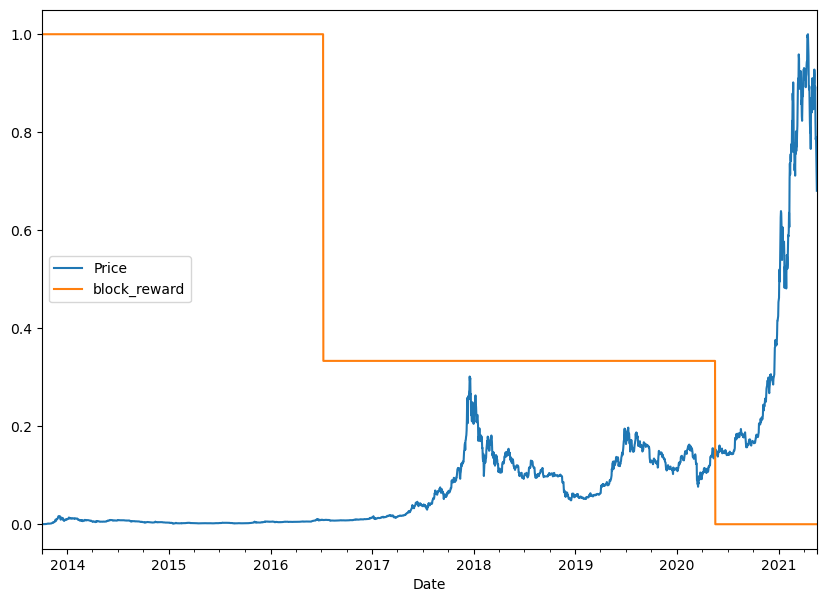

In [70]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),columns=bitcoin_prices_block.columns,index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

In [71]:
#038 Preparing our multivariate time series for a model
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [75]:
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)


In [77]:
split_size = int(len(x)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test=X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [ ]:
#039 Model 6 Building, fitting and evaluating a multivariate time series model
